# Pennylane demo: QAOA for MaxCut

In [124]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# Matplolib style
plt.style.use('https://github.com/kaiuki2000/PitayaRemix/raw/main/PitayaRemix.mplstyle')

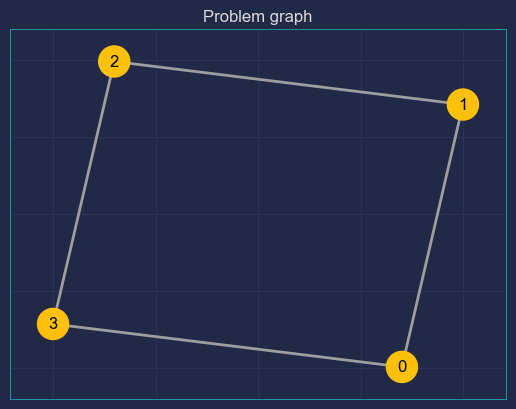

In [125]:
# set the random seed
np.random.seed(42)

# number of qubits in the circuit
n_wires = 4
# graph edges as a list of tuples
graph = [(0, 1), (0, 3), (1, 2), (2, 3)]
graph_nx = nx.Graph(graph)

# set node colors and size
node_colors = ["#FFC107" for node in graph_nx.nodes()]
node_size = 500

# set edge colors and width
edge_colors = ["#9E9E9E" for edge in graph_nx.edges()]
edge_width = 2

# set layout
pos = nx.spring_layout(graph_nx)

# draw graph
nx.draw_networkx(graph_nx, pos=pos, with_labels=True, node_color=node_colors, node_size=node_size, edge_color=edge_colors, width=edge_width)
plt.title("Problem graph")
plt.show()

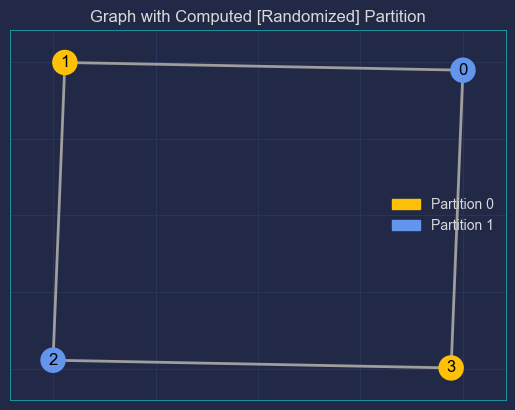

In [126]:
# Call the draw_partition function
def draw_partition(graph, partition):
    # set node colors and size
    node_colors = []
    for node in graph.nodes():
        if node in partition[1][0]:
            node_colors.append("#FFC107")  # color for nodes in partition 0
        else:
            node_colors.append("#6495ED")  # color for nodes in partition 1 (blue shade)

    # set edge colors and width
    edge_colors = ["#9E9E9E" for edge in graph.edges()]
    edge_width = 2

    # set layout
    pos = nx.spring_layout(graph)

    # draw graph
    nx.draw_networkx(graph, pos=pos, with_labels=True, node_color=node_colors, edge_color=edge_colors, width=edge_width)

    # create legend
    partition0_patch = Patch(color='#FFC107', label='Partition 0')
    partition1_patch = Patch(color='#6495ED', label='Partition 1')
    plt.legend(handles=[partition0_patch, partition1_patch])

# Compute the randomized partition
partition = nx.algorithms.approximation.randomized_partitioning(graph_nx, seed=None, p=0.5, weight=None)

# Call the draw_partition function
draw_partition(graph_nx, partition)
plt.title("Graph with Computed [Randomized] Partition")
plt.show()


In [127]:
# Cost and mixer Hamiltonians: Built-in PennyLane functions
cost_h, mixer_h = qml.qaoa.maxcut(graph_nx)
print("Cost Hamiltonian", cost_h)
print("Mixer Hamiltonian", mixer_h)

Cost Hamiltonian   (-2.0) [I0]
+ (0.5) [Z0 Z1]
+ (0.5) [Z0 Z3]
+ (0.5) [Z1 Z2]
+ (0.5) [Z3 Z2]
Mixer Hamiltonian   (1) [X0]
+ (1) [X1]
+ (1) [X3]
+ (1) [X2]


In [128]:
# Penalty term: visualization
qml.qaoa.edge_driver(nx.Graph([(0, 2)]), ['00'])

  (-0.25) [Z0]
+ (-0.25) [Z2]
+ (-0.25) [Z0 Z2]


In [130]:
# unitary operator U_B with parameter beta
def U_B(beta):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)

# unitary operator U_C with parameter gamma
def U_C(gamma):
    for edge in graph:
        wire1 = edge[0]
        wire2 = edge[1]
        # Usual terms
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])
    # Reward first qubit in |0> state only (No penalization for |1> state!)
    # qml.RZ(1*gamma, wires=0)

    # Penalize only the case where the first qubit is in the |1> state.
    # qml.RZ(1*gamma, wires=0)
        
    # Penalize the case where the first qubit is in the |1> state and reward the case where it is in the |0> state.
    # qml.RZ(2*gamma, wires=0)
        
    # Built-in methods:
    # qml.RZ(2*gamma, wires=0); qml.RZ(2*gamma, wires=2)
    # qml.CNOT(wires=[0, 2])
    # qml.RZ(gamma, wires=2)
    # qml.CNOT(wires=[0, 2])
        
# convert a bitstring sample to the corresponding integer
def bitstring_to_int(bit_string_sample):
    bit_string = "".join(str(bs) for bs in bit_string_sample)
    return int(bit_string, base=2)

# initialize the device
dev = qml.device("lightning.qubit", wires=n_wires, shots=1)

# QAOA circuit
@qml.qnode(dev)
def circuit(gammas, betas, edges=None, n_layers=1):
    # apply Hadamards to get the n qubit |+> state
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)
    # p instances of unitary operators
    for i in range(n_layers):
        U_C(gammas[i])
        U_B(betas[i])
    if edges is None:
        # measurement phase
        return qml.sample()
    # during the optimization phase we are evaluating a term
    # in the objective using expval
    B = 1.0; H = 0
    # Reward first qubit in |0> state only (No penalization for |1> state!)
    # H = B * (0.5 * (1 + qml.PauliZ(0)))
        
    # Penalize only the case where the first qubit is in the |1> state.
    # H = B * (0.5 * (-1 + qml.PauliZ(0)))
            
    # Penalize the case where the first qubit is in the |1> state and reward the case where it is in the |0> state.
    # H = B * qml.PauliZ(0)

    # Built-in "reward" - for ['00'] on (0, 2) - term: (Actually reversed, since we want highest cost, C)
    # H = qml.qaoa.edge_driver(nx.Graph([(0, 2)]), ['00'])
    
    for edge in graph:
        H += 0.5 * (1 - qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1]))
    return qml.expval(H)

def qaoa_maxcut(n_layers=1, edges=None):
    print("\nQAOA level: p={:d}".format(n_layers))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, n_layers, requires_grad=True)

    # minimize the negative of the objective function
    def objective(params):
        gammas = params[0]
        betas = params[1]
        # objective for the MaxCut problem
        neg_obj = -1 * circuit(gammas, betas, edges=edges, n_layers=n_layers, shots = 100)
        return neg_obj

    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdagradOptimizer(stepsize=0.5)

    # optimize parameters in objective
    params = init_params
    steps = 30
    for i in range(steps):
        params = opt.step(objective, params)
        if (i + 1) % 5 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, -objective(params)))

    # sample measured bitstrings 100 times
    bit_strings = []
    n_samples = 100
    for i in range(0, n_samples):
        bit_strings.append(bitstring_to_int(circuit(params[0], params[1], edges=None, n_layers=n_layers)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :n_layers]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))
    print(f"Circuit drawing, n_layers={n_layers}:")
    print( qml.draw(circuit)(params[0], params[1], edges=None, n_layers=n_layers) )

    return -objective(params), bit_strings

# perform QAOA on our graph with p=1,2 and
# keep the bitstring sample lists
bitstrings1 = qaoa_maxcut(n_layers=1, edges=graph)[1]
bitstrings2 = qaoa_maxcut(n_layers=2, edges=graph)[1]
bitstrings3 = qaoa_maxcut(n_layers=3, edges=graph)[1]


QAOA level: p=1
Objective after step     5:  2.7000000
Objective after step    10:  2.9800000
Objective after step    15:  3.1400000
Objective after step    20:  3.0400000
Objective after step    25:  3.1600000
Objective after step    30:  3.0800000
Optimized (gamma, beta) vectors:
[[-0.73437335]
 [-1.1356546 ]]
Most frequently sampled bit string is: 0101
Circuit drawing, n_layers=1:
0: ──H─╭●────────────╭●─╭●────────────╭●──RX(-2.27)───────────────────────────────────────
1: ──H─╰X──RZ(-0.73)─╰X─│─────────────│──╭●────────────────────╭●──RX(-2.27)──────────────
2: ──H──────────────────│─────────────│──╰X──────────RZ(-0.73)─╰X─╭●────────────────────╭●
3: ──H──────────────────╰X──RZ(-0.73)─╰X──────────────────────────╰X──────────RZ(-0.73)─╰X

─────────────┤  Sample
─────────────┤  Sample
───RX(-2.27)─┤  Sample
───RX(-2.27)─┤  Sample

QAOA level: p=2
Objective after step     5:  3.2000000
Objective after step    10:  3.8200000
Objective after step    15:  3.9800000
Objective after step 

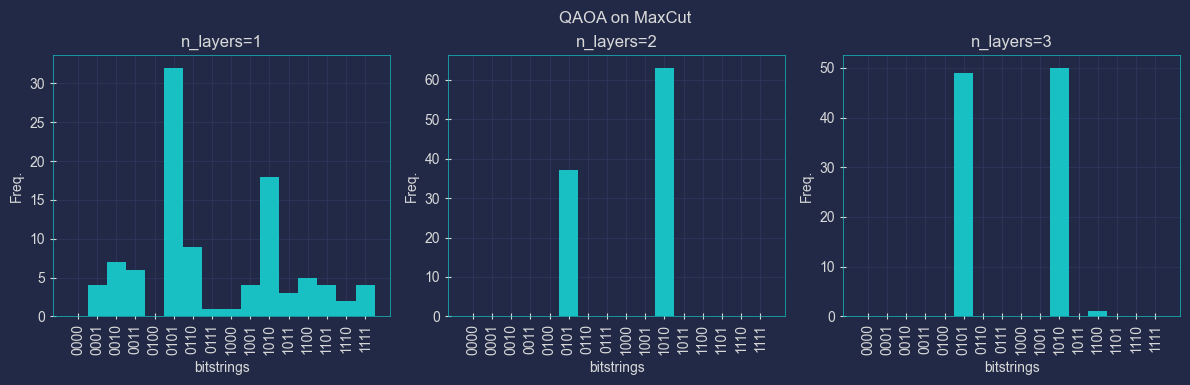

In [131]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

xticks = range(0, 16)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 17) - 0.5

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(f"n_layers={i+1}")
    plt.xlabel("bitstrings")
    plt.ylabel("Freq.")
    plt.xticks(xticks, xtick_labels, rotation="vertical")
    plt.hist(eval(f"bitstrings{i+1}"), bins=bins)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.suptitle("QAOA on MaxCut", x = 0.525, y=0.95) # adjust suptitle position
plt.tight_layout()
plt.show()

In [132]:
# fix seed to make results reproducable
np.random.seed(1)

dev = qml.device("lightning.qubit", wires=1, shots = 1)

@qml.qnode(dev)
def circuit():
    qml.Hadamard(wires=0)
    return qml.expval(qml.PauliZ(0))

In [133]:
circuit(shots = None)

tensor(0., requires_grad=True)